# Assignment 3 - Data Analytics 1

**TeamId** : 6

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sklearn.model_selection import train_test_split

from itertools import combinations

----
## 1. Data Preprocessing

### 1.1 Load Data
from the the folder in ml-latest-small which contains the following files:
- `links.csv`
    - contains:
        - `movieId`
        - `imdbID`
        - `tmdbId`
- `movies.csv`
    - contains:
        - `movieId`
        - `title`
        - `genres`
- `ratings.csv`
    - contains:
        - `userId`
        - `movieId`
        - `rating`
        - `timestamp`
- `tags.csv`
    - contains:
        - `userId`
        - `movieId`
        - `tag`
        - `timestamp`

In [2]:
# loafing csv to dataframes
df_links = pd.read_csv('ml-latest-small/links.csv')
df_movies = pd.read_csv('ml-latest-small/movies.csv')
df_ratings = pd.read_csv('ml-latest-small/ratings.csv')
df_tags = pd.read_csv('ml-latest-small/tags.csv')

# print the shape of the dataframes
df_links.shape,df_movies.shape,df_ratings.shape,df_tags.shape

((9742, 3), (9742, 3), (100836, 4), (3683, 4))

In [3]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### 1.2 Form the transactional data set, which consists of entries of the form:

$\{userId, \text{<movies rated above 2>}\}$

In [4]:
transactional_dic = {}

# first get the unique user ids
unique_user_ids = df_ratings['userId'].unique()

# loop through the unique user ids and get the movies they have rated
for user_id in tqdm.tqdm(unique_user_ids):
    transactional_dic[user_id] = df_ratings[df_ratings['userId']==user_id]['movieId'].values

100%|██████████| 610/610 [00:00<00:00, 1405.30it/s]


### 1.3 Consider only those users who have rated more than 10 movie

In [5]:
print('Number of users: ',len(transactional_dic.keys()))

# prune users who have rated less than 10 movies
for user_id in list(transactional_dic.keys()):
    if len(transactional_dic[user_id]) < 10:
        del transactional_dic[user_id]
        
print('Number of users (rated more than 10 movies): ',len(transactional_dic.keys()))

Number of users:  610
Number of users (rated more than 10 movies):  610


#### 1.4.1 Divide the data set into 80% training set and 20% test set.

Divide the data set into 80% training set and 20% test set. Remove 20% of
movies watched from each user and create a test set using the removed
movies

In [6]:
# remove 20% of the movies from each user's list to get train and store the removed movies as test
user_ids = list(transactional_dic.keys())

# Split the data
train_dic = {}
test_dic = {}
for user_id in user_ids:
    train_dic[user_id], test_dic[user_id] = train_test_split(transactional_dic[user_id], test_size=0.2, random_state=42)

# Convert lists to DataFrames
train_df = pd.DataFrame(train_dic.items(), columns=['userId', 'moviesRatedAbove2'])
test_df = pd.DataFrame(test_dic.items(), columns=['userId', 'moviesRatedAbove2'])

In [7]:
print('Train shape: ',train_df.shape)
print('Test shape: ',test_df.shape)

Train shape:  (610, 2)
Test shape:  (610, 2)


In [8]:
print('Number of users in train: ',len(train_dic.keys()))
print('Number of users in test: ',len(test_dic.keys()))

Number of users in train:  610
Number of users in test:  610


----
## 1. Association Rule Mining

---
### 1.1 From the training set, extract the set of all association rules of form X→Y,

Where X contains a single movie and Y contains the set of movies from the
training set by employing the apriori or FPgrowth approach and set some
minsup and minconf (eg : 50 and 0.1 respectively)

In [9]:
MINIMUM_SUPPORT = 70
MINIMUM_CONFIDENCE = 0.1

-----
### 1.2 FP-node class

This class will be used to create the FP-tree. Each node will have the following attributes:
- `item_name` : name of the item
- `count` : count of the item
- `parent` : parent of the node
- `children` : list of children of the node
- `link` : pointer to the next node with the same item name 

In [10]:
class FP_Node:
    def __init__(self,item,frequency,parent):
        self.item = item
        self.frequency = frequency
        self.parent = parent
        self.children = {}
        self.link = None

In [11]:
class FP_Tree:
    def __init__(self,transactions,min_support):
        self.head = FP_Node(None,None,None)
        
        # transaction should be a list of tuple (timeset,frequency)
        assert type(transactions) == list
        assert type(transactions[0]) == list
        assert type(transactions[0][0]) == list
        assert type(transactions[0][1]) == int
        
        self.transactions = transactions
        self.min_support = min_support
        
        self.item_frequency = {}
        self.header_table = {}
        
    def print_tree(self):
        self.print_tree_structure(self.head)
        
    def print_tree_structure(self, node, indent=" "):
        if node.item == -1:
            print(f"{indent}Root")
        else:
            print(f"{indent}Item: {node.item} Frequency: {node.frequency}")
        for child in node.children.values():
            self.print_tree_structure(child, indent + "|---->")
        
    def get_frequent_items(self):
        item_freqency = {}
        
        for transaction in self.transactions:
            for item in transaction[0]:
                if item in item_freqency:
                    item_freqency[item] += transaction[1]
                else:
                    item_freqency[item] = transaction[1]
                    
        item_freqency = {k:v for k,v in item_freqency.items() if v >= self.min_support}
        
        # order the items based on the frequency
        item_freqency = dict(sorted(item_freqency.items(),key=lambda x:x[1],reverse=True))
        
        return item_freqency
    
    def build_tree(self):
        # get the frequent items
        self.item_frequency = self.get_frequent_items()
        
        # reorder the transactions based on the frequency of the items
        for transaction in self.transactions:
            transaction[0] = [item for item in transaction[0] if item in self.item_frequency]
            transaction[0].sort(key=lambda x: self.item_frequency[x],reverse=True)
        
        # now add the transactions to the tree
        for transaction in self.transactions:
            self.insert_transaction(transaction[0],transaction[1])
        
        # todo format the header table
        new_header_table = {}
        
        for item in self.header_table:
            new_header_table[item] = [self.item_frequency[item],self.header_table[item]]
        
        self.header_table = new_header_table
        
        return self.header_table
    
    def insert_transaction(self,itemset,frequency):
        curr_node = self.head
        
        for item in itemset:
            if item in curr_node.children:
                curr_node.children[item].frequency += frequency
            else:
                curr_node.children[item] = FP_Node(item, frequency, curr_node)
                
                # add the node is added to heads table list of linked nodes
                if item not in self.header_table:
                    self.header_table[item] = curr_node.children[item]
                else:
                    node = self.header_table[item]
                    while node.link is not None:
                        node = node.link
                    node.link = curr_node.children[item]
            curr_node = curr_node.children[item]

In [12]:
def get_path_from_node(node):
        frequency = node.frequency
        curr_node = node.parent
        
        path = []
        
        while curr_node.parent is not None:
            path.append(curr_node.item)
            curr_node = curr_node.parent
            
        return path,frequency
    
def get_conditional_patterns_heads(header_table):
    conditional_patterns_heads = []
    
    for item in header_table:
        diff_paths = get_conditional_patterns(header_table[item][1])            
        conditional_patterns_heads.append([item,diff_paths])
            
    return conditional_patterns_heads

def get_conditional_patterns(node):
    diff_paths = []
    
    curr_node = node
    while curr_node is not None:
        path,frequency = get_path_from_node(curr_node)
        if len(path) > 0:
            diff_paths.append([path,frequency])
        
        curr_node = curr_node.link
    
    return diff_paths

In [13]:
def fp_growth(headerTable, minSup, preFix, freqItemList):
    # sort the items in the header table based on the frequency
    items = [item[0] for item in sorted(headerTable.items(),key=lambda x:x[1][0])]
    
    for item in items:
        new_freq_set = preFix.copy()
        new_freq_set.add(item)
        freqItemList.append(new_freq_set)
        
        conditional_pattern_bases = get_conditional_patterns(headerTable[item][1])
            
        if conditional_pattern_bases == []:
            continue
        
        # build the conditional tree
        conditional_tree = FP_Tree(conditional_pattern_bases,minSup)
        conditional_header_table = conditional_tree.build_tree()
        
        if conditional_tree.header_table != {}:
            fp_growth(conditional_header_table,minSup,new_freq_set,freqItemList)

In [14]:
def get_subset(items):
    subset_list = []
    for i in range(1,len(items)):
        subset = list(combinations(items,i))
        
        if len(subset) > 0:
            subset_list.extend(subset)
    
    return subset_list

def get_support(itemSet, transactions):
    support = 0

    for transaction in transactions:
        if set(itemSet).issubset(set(transaction)):
            support += 1

    return support

def associationRule(freqItemSet,orgItemSet,min_confidence):
    rules = []
    
    for itemSet in tqdm.tqdm(freqItemSet):
        # get the subsets of the itemset
        subsets = get_subset(itemSet)

        # support count
        support_count = get_support(itemSet, orgItemSet)
            
        # loop through the subsets and get the confidence
        for subset in subsets:
            antecedent = list(subset)
            consequent = list(set(itemSet) - set(antecedent))
            
            # support count
            subset_suport_count = get_support(antecedent, orgItemSet)
            
            # support calculation
            support = support_count / len(orgItemSet)
            subset_support = subset_suport_count / len(orgItemSet)
            
            # get the confidence
            confidence = float(support/subset_support) 
            
            if confidence >= min_confidence:
                rules.append([antecedent, consequent, support, confidence])
    return rules
        

---------------------
#### Example

In [15]:
# Example usage
org_ex_transactions =  [['p', 'm', 'a', 'c', 'f'],
                    ['m', 'b', 'a', 'c', 'f'],
                    ['b', 'f'],
                    ['p', 'b', 'c'],
                    ['p', 'm', 'a', 'c', 'f']]

ex_min_support = 3
ex_min_confidence = 0.1

# convert the transactions into the required format
ex_transactions = [[list(item),1] for item in org_ex_transactions]

# build the tree
ex_tree = FP_Tree(ex_transactions,ex_min_support)

# build the tree
ex_header_table = ex_tree.build_tree()

# mine the tree
freqItemsList = []
prefix = set()
fp_growth(ex_header_table,ex_min_support,prefix,freqItemsList) 
rules = associationRule(freqItemsList, org_ex_transactions, ex_min_confidence)

print("---"*10,"RESULTS","---"*10)   


print("\nFrequent Itemsets:")
for itemset in freqItemsList:
    print(', '.join(itemset))
print("-"*20)

print("\nAssociation Rules:")
for rule in rules[:10]:
    left, right, support, confidence = rule
    print(f"{left}\t=>\t{right}, \t\tSupport: {support:.5f}, \tConfidence: {confidence:.5f}")

100%|██████████| 18/18 [00:00<00:00, 18070.24it/s]

------------------------------ RESULTS ------------------------------

Frequent Itemsets:
p
c, p
m
m, f
m, c
m, c, f
a
a, m
a, f
a, m, f
a, c
a, c, f
a, m, c
a, m, c, f
b
c
f
c, f
--------------------

Association Rules:
['c']	=>	['p'], 		Support: 0.60000, 	Confidence: 0.75000
['p']	=>	['c'], 		Support: 0.60000, 	Confidence: 1.00000
['m']	=>	['f'], 		Support: 0.60000, 	Confidence: 1.00000
['f']	=>	['m'], 		Support: 0.60000, 	Confidence: 0.75000
['m']	=>	['c'], 		Support: 0.60000, 	Confidence: 1.00000
['c']	=>	['m'], 		Support: 0.60000, 	Confidence: 0.75000
['m']	=>	['c', 'f'], 		Support: 0.60000, 	Confidence: 1.00000
['c']	=>	['m', 'f'], 		Support: 0.60000, 	Confidence: 0.75000
['f']	=>	['m', 'c'], 		Support: 0.60000, 	Confidence: 0.75000
['m', 'c']	=>	['f'], 		Support: 0.60000, 	Confidence: 1.00000


------
### Generate the FP-tree from the training set

In [16]:
# now lets run the algorithm on the train data
train_transactions = [[list(item),1] for item in train_dic.values()]

# build the tree
train_tree = FP_Tree(train_transactions,MINIMUM_SUPPORT)

# build the tree
train_header_table = train_tree.build_tree()

# mine the tree
freqItemsList = []
prefix = set()

----
#### Generate the frequent itemsets from the FP-tree

In [17]:
# generate the frequent itemsets
fp_growth(train_header_table,MINIMUM_SUPPORT,prefix,freqItemsList)

# print the count of frequent itemsets
print('Number of frequent itemsets: ',len(freqItemsList))

Number of frequent itemsets:  590


----
#### Generate the association rules from the frequent itemsets

In [18]:
# get the association rules
rules = associationRule(freqItemsList, train_dic.values(), MINIMUM_CONFIDENCE)

# print total number of rules
print('Number of raw rules: ',len(rules))

# sort them in descending order of confidence
rules_by_conf = sorted(rules,key=lambda x:x[3],reverse=True)

# sort them in descending order of support
rules_by_sup = sorted(rules,key=lambda x:x[2],reverse=True)

100%|██████████| 590/590 [00:16<00:00, 35.25it/s]

Number of raw rules:  952


In [19]:
# now get top 100 rules by confidence and support
top_100_rules_by_conf = rules_by_conf[:100]
top_100_rules_by_sup = rules_by_sup[:100]

# prnt len of top 100 rules
print('Number of top 100 rules by confidence: ',len(top_100_rules_by_conf))
print('Number of top 100 rules by support: ',len(top_100_rules_by_sup))

Number of top 100 rules by confidence:  100
Number of top 100 rules by support:  100


In [20]:
# Print the top 10 rules by confidence
print('Top 10 rules by confidence: ')
print("{:<30} {:<30} {:<20} {:<20}".format('Left', 'Right', 'Support', 'Confidence'))

for i, rule in enumerate(top_100_rules_by_conf[:10], 1):
    left, right, support, confidence = rule
    left_str = ', '.join(map(str, left))
    right_str = ', '.join(map(str, right))
    print("{:<30} {:<30} {:<20.5f} {:<20.5f}".format(left_str, right_str, support, confidence))

print('-'*100,'\n')

# Print the top 10 rules by support
print('Top 10 rules by support: ')
print("{:<30} {:<30} {:<20} {:<20}".format('Left', 'Right', 'Support', 'Confidence'))

for i, rule in enumerate(top_100_rules_by_sup[:10], 1):
    left, right, support, confidence = rule
    left_str = ', '.join(map(str, left))
    right_str = ', '.join(map(str, right))
    print("{:<30} {:<30} {:<20.5f} {:<20.5f}".format(left_str, right_str, support, confidence))

Top 10 rules by confidence: 
Left                           Right                          Support              Confidence          
260, 2959                      2571                           0.12459              0.86364             
296, 2762                      2571                           0.11639              0.80682             
7153, 260                      4993                           0.11803              0.80000             
7153, 260                      2571                           0.11803              0.80000             
1221                           858                            0.13607              0.79808             
4993, 260                      2571                           0.11967              0.79348             
4993, 260                      7153                           0.11803              0.78261             
1210, 2571                     260                            0.12295              0.78125             
356, 2959                      2571

In [21]:
# convert the rules into a dataframe
column_names = ['antecedents', 'consequents', 'support', 'confidence']

# Convert the list of lists to a DataFrame
df_top_100_rules_by_conf = pd.DataFrame(top_100_rules_by_conf, columns=column_names)
df_top_100_rules_by_sup = pd.DataFrame(top_100_rules_by_sup, columns=column_names)

# convert rules into a dataframe
df_rules = pd.DataFrame(rules, columns=column_names)

# format the anteceents and consequents
df_top_100_rules_by_conf['antecedents'] = df_top_100_rules_by_conf['antecedents'].map(tuple)
df_top_100_rules_by_conf['consequents'] = df_top_100_rules_by_conf['consequents'].map(tuple)

df_top_100_rules_by_sup['antecedents'] = df_top_100_rules_by_sup['antecedents'].map(tuple)
df_top_100_rules_by_sup['consequents'] = df_top_100_rules_by_sup['consequents'].map(tuple)

df_rules['antecedents'] = df_rules['antecedents'].map(tuple)
df_rules['consequents'] = df_rules['consequents'].map(tuple)

------
### Store the association rules in a file

format of the file:
- 6_top100RulesByConf (.txt)
- 6_top100RulesBySup (.txt)

In [22]:
# store them all the top 100 ruls in a txt file
with open('6_top100RulesByConf.txt','w') as f:
    for rule in top_100_rules_by_conf:
        left, right, support, confidence = rule
        left_str = ', '.join(map(str, left))
        right_str = ', '.join(map(str, right))
        f.write("{:<30} {:<30} {:<20.5f} {:<20.5f}\n".format(left_str, right_str, support, confidence))
        
with open('6_top100RulesBySup.txt','w') as f:
    for rule in top_100_rules_by_sup:
        left, right, support, confidence = rule
        left_str = ', '.join(map(str, left))
        right_str = ', '.join(map(str, right))
        f.write("{:<30} {:<30} {:<20.5f} {:<20.5f}\n".format(left_str, right_str, support, confidence))

----
### Recommendation

Identify the rules that appear in both lists, and then arrange these shared
rules based on their confidence score

In [23]:
# Sort by support and get top 100
top_support_rules = df_top_100_rules_by_conf.sort_values(by='support', ascending=False).head(100)

# Sort by confidence and get top 100
top_confidence_rules = df_top_100_rules_by_sup.sort_values(by='confidence', ascending=False).head(100)

# Identify rules that appear in both lists
common_rules = pd.merge(top_support_rules, top_confidence_rules, how='inner', on=['antecedents', 'consequents'])

# Arrange these shared rules based on their confidence
common_rules_sorted_by_confidence = common_rules.sort_values(by='confidence_x', ascending=False)

# Display the rules
print(common_rules_sorted_by_confidence[['antecedents', 'consequents', 'support_x', 'confidence_x']])

   antecedents consequents  support_x  confidence_x
12     (1210,)      (260,)   0.177049      0.729730
5      (7153,)     (4993,)   0.186885      0.726115
7      (5952,)     (4993,)   0.181967      0.711538
11     (2762,)     (2571,)   0.177049      0.710526
14     (2028,)     (2571,)   0.173770      0.706667
10     (5952,)     (7153,)   0.180328      0.705128
1      (1196,)      (260,)   0.196721      0.701754
2      (1196,)     (2571,)   0.196721      0.701754
9      (7153,)     (5952,)   0.180328      0.700637
4      (4993,)     (7153,)   0.186885      0.699387
13     (7153,)     (2571,)   0.177049      0.687898
3      (2959,)     (2571,)   0.190164      0.686391
6      (4993,)     (5952,)   0.181967      0.680982
15      (377,)      (356,)   0.160656      0.671233
0       (480,)      (356,)   0.198361      0.668508
8       (150,)      (356,)   0.180328      0.662651


----

### Taking a sample example of users and their movie ratings from the test set and Display precision and recall graphs.

In [24]:
def get_recomendations(user, train, rule, num_rules):
    recommendations = set()
    
    user_movies = set(train[train['userId']==user]['moviesRatedAbove2'].values[0])
    
    # need to get revelant rules for the user
    for movie in user_movies:
        relevant_rules = rule[rule['antecedents'].apply(lambda x: movie in x)]
        
        # sort the rules by confidence
        relevant_rules = relevant_rules.sort_values(by='confidence',ascending=False)
        
        # now update the recommendations
        for i in range(len(relevant_rules)):
            recommendations.update(relevant_rules['consequents'].values[i])
            
            if len(recommendations) >= num_rules:
                break
            
    return recommendations

In [25]:
# format the anteceents 
df_rules['antecedents'] = df_rules['antecedents'].apply(frozenset)

# Create a dictionary mapping each movie to its top 10 association rules by confidence
movie_to_rules = {}
for movie in df_rules['antecedents'].explode().unique():
    top_rules = df_rules[df_rules['antecedents'] == frozenset({movie})].nlargest(10, 'confidence')
    movie_to_rules[movie] = top_rules

610it [13:17,  1.31s/it]


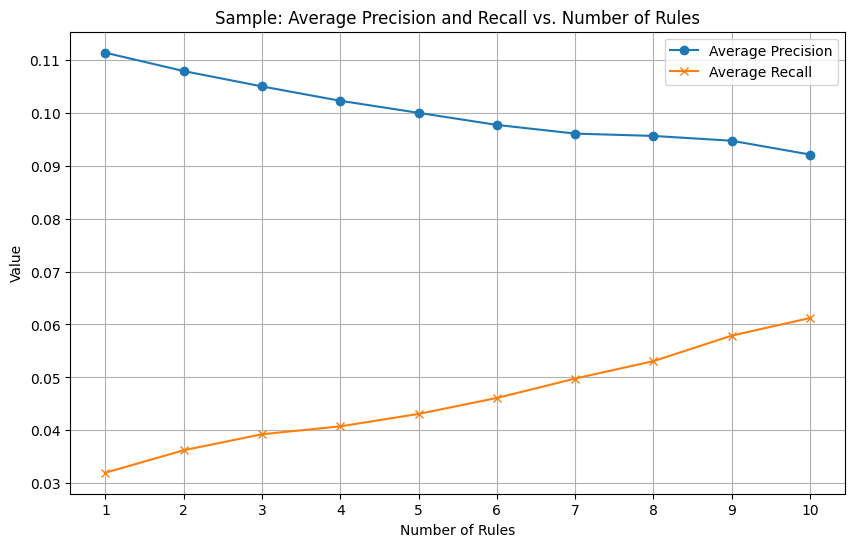

In [26]:
# Initial setup for this sample
sample_precisions = []
sample_recalls = []

# Iterate over each user i
for _, row in tqdm.tqdm(test_df.iterrows()):
    user = row['userId']
    test_movies = set(row['moviesRatedAbove2'])
    train_movies = set(train_df[train_df['userId'] == user]['moviesRatedAbove2'].iloc[0])

    user_precisions = []
    user_recalls = []

    # For varying number of rules from 1 to 10
    for num_rules in range(1, 11):
        recommendations = get_recomendations(user, train_df, df_rules, num_rules)
        
        # Compute the hit set
        hit_set = recommendations.intersection(test_movies)

        # Calculate precision and recall
        precision = len(hit_set) / len(recommendations) if recommendations else 0
        recall = len(hit_set) / len(test_movies) if len(test_movies) else 0

        user_precisions.append(precision)
        user_recalls.append(recall)

    sample_precisions.append(user_precisions)
    sample_recalls.append(user_recalls)

# Compute average precision and recall for this sample
avg_sample_precisions = np.mean(sample_precisions, axis=0)
avg_sample_recalls = np.mean(sample_recalls, axis=0)

# Plotting
plt.figure(figsize=(10, 6))
x = range(1, 11)
plt.plot(x, avg_sample_precisions, marker='o', label='Average Precision')
plt.plot(x, avg_sample_recalls, marker='x', label='Average Recall')
plt.title('Sample: Average Precision and Recall vs. Number of Rules')
plt.xlabel('Number of Rules')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(x)
plt.show()

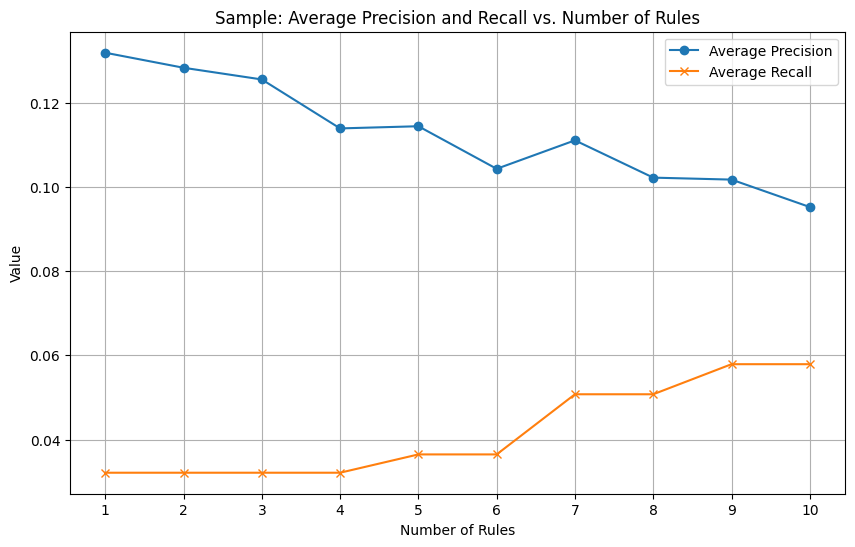

In [29]:
# Sample a subset of users from test_df
sample_test_df = test_df.sample(10)

# Initial setup for this sample
sample_precisions = []
sample_recalls = []

# Iterate over each user in the sample_test_df
for _, row in sample_test_df.iterrows():
    user = row['userId']
    test_movies = set(row['moviesRatedAbove2'])
    train_movies = set(train_df[train_df['userId'] == user]['moviesRatedAbove2'].iloc[0])

    user_precisions = []
    user_recalls = []

    # For varying number of rules from 1 to 10
    for num_rules in range(1, 11):
        recommendations = get_recomendations(user, train_df, df_rules, num_rules)
        
        # Compute the hit set
        hit_set = recommendations.intersection(test_movies)

        # Calculate precision and recall
        precision = len(hit_set) / len(recommendations) if recommendations else 0
        recall = len(hit_set) / len(test_movies)

        user_precisions.append(precision)
        user_recalls.append(recall)

    sample_precisions.append(user_precisions)
    sample_recalls.append(user_recalls)

# Compute average precision and recall for this sample
avg_sample_precisions = np.mean(sample_precisions, axis=0)
avg_sample_recalls = np.mean(sample_recalls, axis=0)

# Plotting
plt.figure(figsize=(10, 6))
x = range(1, 11)
plt.plot(x, avg_sample_precisions, marker='o', label='Average Precision')
plt.plot(x, avg_sample_recalls, marker='x', label='Average Recall')
plt.title('Sample: Average Precision and Recall vs. Number of Rules')
plt.xlabel('Number of Rules')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(x)
plt.show()